# Social Network Analysis group project 📊

***

## Group members 👥
- Michele Turco
- Simone Filosofi
- Edoardo Cocciò
- Lorenzo Laterza

# General Introduction



The graph we have choosen is "Forrest Gump (movie) network". 

This graph is undirected and weighted.
Nodes are characters and the link represent a same-scene appearance between two characters in the movie,
and the weight gives the number of same-scene appearances.

Source: J. Kaminski et al., "Moviegalaxies - Social Networks in Movies." 


# Importing libraries  

In [2]:
import networkx as nx # this is for network analysis
import pandas as pd # this is for data analysis
import matplotlib.pyplot as plt # this is for plotting
import json # this is for reading json files

# 1) Week 1

a) Implement it in Python.

b) Draw the graph

c) Compute the number of nodes,edges, average degree and the density. Comment.

# Reading the input file

In [10]:
nodes_df = pd.read_csv('data/nodes.csv', index_col=0,sep = ',')
edges_df = pd.read_csv('data/edges.csv')

nodes_df[' viz'] = nodes_df[' viz'].apply(lambda row: row.replace("'", '"')).apply(json.loads) # Separating the values in the _viz column in order to access them later
nodes_df['size'] = nodes_df[' viz'].apply(lambda row: row['size'] * 55) # Scaling the nodes

nodes_df[' _pos'] = nodes_df[' _pos'].apply(lambda row: (float(row[7:18]), float(row[20:-2])))

# a) Implementing the graph

In [4]:
links = edges_df['coordinates'] = edges_df.apply(lambda row: (row['# source'], row[' target'], row[' weight']), axis=1)

labels = enumerate(nodes_df[' label'])
labels = dict(labels)

pos = nodes_df[' _pos']

colors = []
for n in range(0,94):
    color = nodes_df[' viz'][n]['color']
    accepted_format = (color['r']/255, color['g']/255, color['b']/255, color['a'])
    colors.append(accepted_format)

# b) Draw the graph

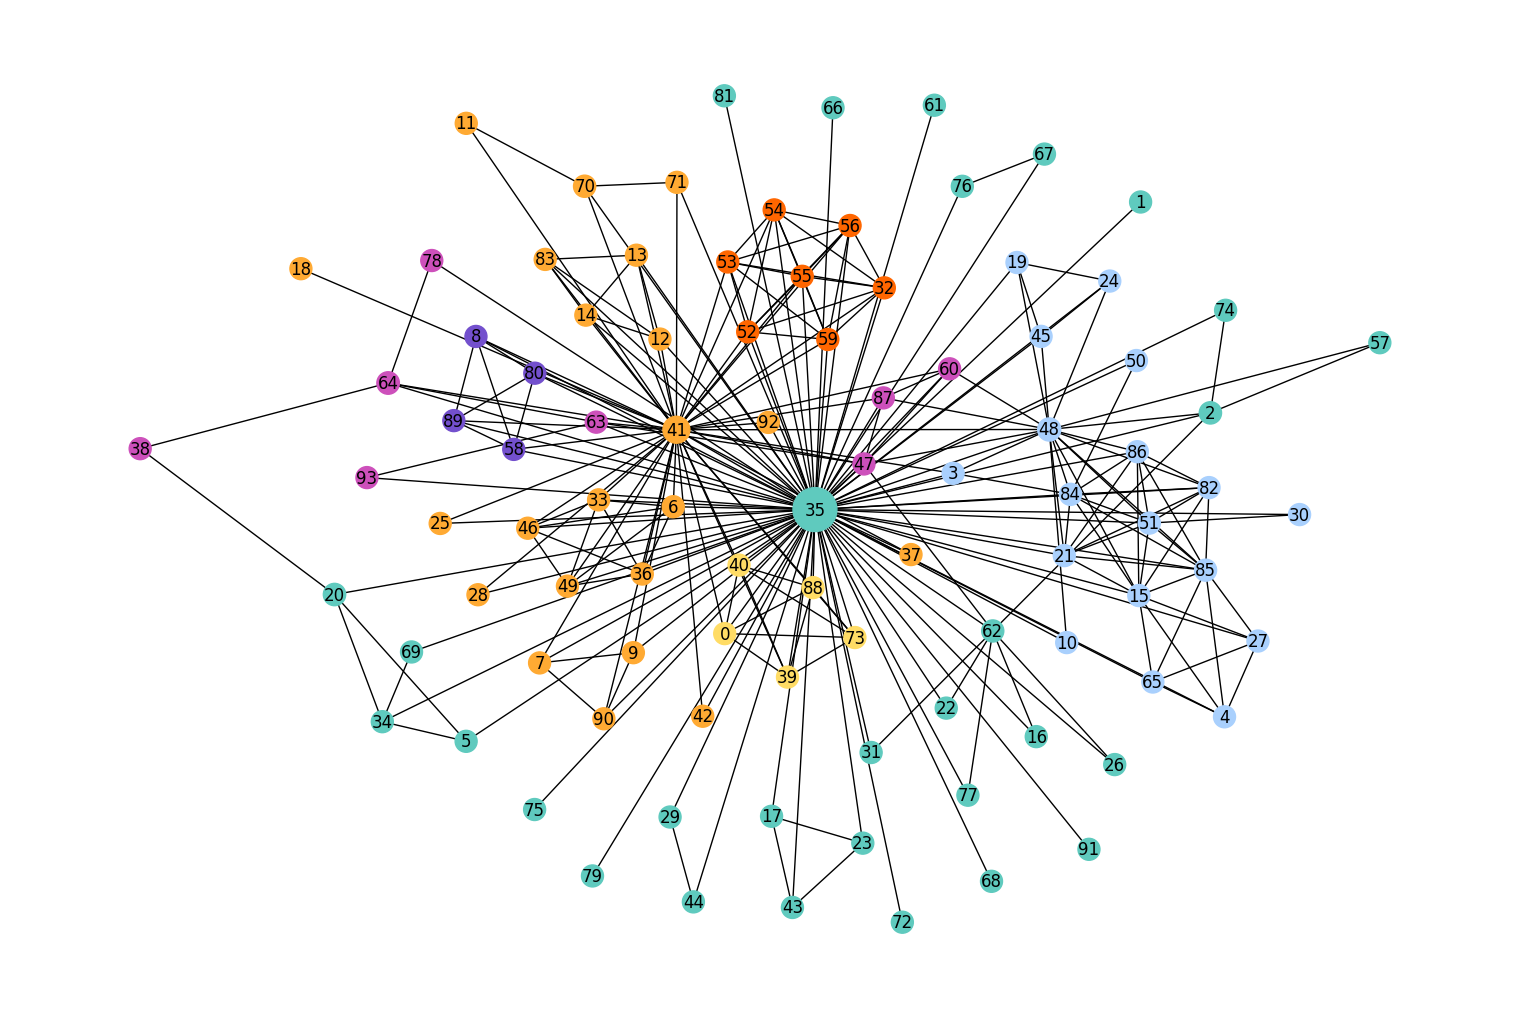

In [11]:
plt.figure(figsize=(15, 10))
G = nx.Graph()

for n in range(0, len(nodes_df)):
    G.add_node(n)

G.add_weighted_edges_from(links)
nx.set_node_attributes(G, labels, name = 'label')


nx.draw(G, node_size = nodes_df['size'], pos = pos, with_labels = True, node_color = colors)

# c) Compute:

### - Number of nodes

In the film appear 94 characters, so the number of nodes is 94.

In [5]:
G.number_of_nodes()

94

### - Number of edges

In [6]:
G.number_of_edges()

271

### - Average degree


In [7]:
Average_degree = 2 * G.number_of_edges() / G.number_of_nodes()
print(Average_degree)

5.76595744680851


### - Density

The density is very low (0.06199954243880119). 

It means that here are relatively few edges compared to the total number of possible edges in the graph.


In [8]:
nx.density(G)

0.06199954243880119

# 2) Week 2

While considering the largest component of your network.

a) Compute Average clustering and Transitivity number

b) Implement a function computing the transitivity using basic function of networkx

# Checking what's the largest component of the graph
Since all nodes are connected we are considering the entire graph for the following computations

In [9]:
cc = [i for i in nx.connected_components(G)]
len(cc)

1

### Diameter

In [10]:
nx.diameter(G) # the maximum distance between two nodes iinside the graph

4

### Average Shortest Path Length

In [11]:
nx.average_shortest_path_length(G)

1.9949668268130862

# a) Average Clustering

In [12]:
nx.average_clustering(G)

0.8002425574908809

# b) Transitivity implementation using basic networkx functions

In [13]:
# T = 3 * (Number of triangles) / ( N(N-1) / 2 )

def count_triangles(G):
    "Count the number of triangles in the graph without using nx.triangles "
    triangles = 0
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                u, v = neighbors[i], neighbors[j]
                if G.has_edge(u, v):
                    triangles += 1
    return triangles   # Each triangle is counted 3 times (once for each node)

def transitivity(G):
# Actual number of triangles is 'triangles'/3, but the denominator semplifies with the '3' in the main formula

    triangles = count_triangles(G) # number of triangles inside the graph
    sum_of_degrees = 0

    for node in G.nodes():
        fraction = (G.degree(node) * (G.degree(node) - 1))/2 # number of wedges
        sum_of_degrees += fraction

    return triangles / sum_of_degrees

print(f"Transitivity results:\n---------------------------------------  \nOur implementation: {transitivity(G)} \nNetworkx: {nx.transitivity(G)}")


Transitivity results:
---------------------------------------  
Our implementation: 0.1918081918081918 
Networkx: 0.1918081918081918


# 3) Week 3

Depending on what seems more relevant in your graph, pick one of the following local notions:
- Decay centrality 
- Betweeness centrality 
- Closeness centrality 
- Clustering
- Any other notions that you invent

a) Provide a code computing the given centrality using basic functions of networkx (you are not allowed to use directly nx."what you want").

b) Discuss why you picked this measure and who is the most central in your network based on your choice.

c) Provide the cumulative distribution for this centrality and give a graphical representation of your graph (log-log, log or normal representation as you think it is more relevant).

# a) Closeness centrality 


To compute the **closeness centrality of node** _i_:
$$g_{i} = \frac{1}{\sum\limits_{i \ne j}\ell(i,j)}$$
where $\ell(i,j)$ is the distance (shortest path) between the two nodes.

To get a more relevant result we compute the **normalized closeness centrality**:
$$C_{i}^{clo} = g_{i}\cdot (N-1) = \frac{N - 1}{\sum\limits_{i \ne j}\ell(i,j)}$$

In [14]:
# The following function is needed to calculate the shortest path length between two nodes. We used a modified bfs approach to traverse the graph and stored the shortest path in a list containing the interested nodes. 

def shortest_path(graph, start, target):
    path_list = [[start]]
    path_index = 0
    # To keep track of previously visited nodes
    previous_nodes = {start}

    # If the starting node is equal to the target the shortest path between the two is zero
    if start == target:
        return path_list[0]
        
    while path_index < len(path_list):
        current_path = path_list[path_index]
        last_node = current_path[-1]
        next_nodes = graph[last_node]
        # Search target node
        if target in next_nodes:
            current_path.append(target)
            return current_path[1:]
        # Add new paths
        for next_node in next_nodes:
            if not next_node in previous_nodes:
                new_path = current_path[:]
                new_path.append(next_node)
                path_list.append(new_path)
                # To avoid backtracking
                previous_nodes.add(next_node)
        # Continue to next path in list
        path_index += 1
    # In case no path is found
    return []

# b) Why we picked Closeness centrality
We chose to calculate this centrality measure because it is a relevant metric to highlight interconnectedness and prominence of different elements within our dataset, offering valuable insights about the relationships of characters. In the context of character interaction, closeness centrality helps us to identify which characters are central to the storyline and have close ties with other characters.

More specifically we chose to calculate the closeness centrality of `node 35`(Forrest) and `node 41`(Jenny) as they are the most visible nodes that also have the highest number of links (check the representation of the graph).

In [15]:
# This is the main function that calculates the shortest paths: 
# We saved computations and time complexity of the algorithm by adding a simple logic that checks if a direct link is present between the two nodes, if that is the case their shortest path would surely be 1. In all other cases we compute it using the function declared above.
# The result is stored in a dictionary having the target node as a key and the length of the shortest path as value.

def shortest_paths(graph, start):

    spl = dict()

    for node in graph.nodes():
        if (start, node) in graph.edges():
            spl[node] = 1
        else:
            spl[node] = len(shortest_path(G,start,node))

    return spl

In [16]:
# This function trivially applies the formula of the closeness centrality using the values that we previously computed 

def normalized_closeness_centrality(graph, node):
    return (len(graph.nodes()) - 1) / sum(shortest_paths(graph, node).values())

print(f"Centrality of node 35 (Forrest) is: {normalized_closeness_centrality(G, 35)}")
print(f"Centrality of node 41 (Jenny) is: {normalized_closeness_centrality(G,41)}")

Centrality of node 35 (Forrest) is: 0.9489795918367347
Centrality of node 41 (Jenny) is: 0.6549295774647887


# Interpreting the closeness centrality results 🔍

- For node 35, with a centrality of approximately **0.949**, this suggests that it is **highly central within the network**. Nodes with high centrality values like this one often have shorter average distances to all other nodes, meaning they are well-connected and can efficiently communicate or interact with a large portion of the network. As expected, this node plays a crucial role in the network's overall structure and information flow because it is the protagonist of the film: Forrest.

- On the other hand, for node 41 (which is Jenny, Forrest's wife), with a centrality of approximately **0.655**, it also holds a **relatively high** centrality value, indicating that it is important within the network, although not as central as Forrest. This node has meaningful connections and interactions within the network but is not as influential as node 35. It still plays a significant role in the network's structure and communication pathways.

# c) Cumulative distribution function

$$F(x) = P(X \le x)$$

In [17]:
sp = []
for node in G.nodes():
    sp.append(normalized_closeness_centrality(G, node))

centralities_sorted = sorted(sp)
counter = {} 
for value in centralities_sorted:
  if value not in counter:
    counter[value] = 1
  else: # that value is already in the dictionary, just update the counter
    counter[value] += 1

[0.34317343173431736, 0.36046511627906974, 0.3974358974358974, 0.39914163090128757, 0.48947368421052634, 0.48947368421052634, 0.48947368421052634, 0.48947368421052634, 0.48947368421052634, 0.48947368421052634, 0.48947368421052634, 0.48947368421052634, 0.48947368421052634, 0.49206349206349204, 0.49206349206349204, 0.49206349206349204, 0.49206349206349204, 0.49206349206349204, 0.49206349206349204, 0.49206349206349204, 0.49206349206349204, 0.49206349206349204, 0.49206349206349204, 0.49206349206349204, 0.49206349206349204, 0.49206349206349204, 0.4946808510638298, 0.4946808510638298, 0.4946808510638298, 0.4946808510638298, 0.4946808510638298, 0.4946808510638298, 0.49732620320855614, 0.49732620320855614, 0.49732620320855614, 0.49732620320855614, 0.49732620320855614, 0.49732620320855614, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5027027027027027, 0.5027027027027027, 0.5027027027027027, 0.5027027027027027, 0.5027027027027027, 0.5054347826086957, 0.5054347826086957, 0.5054347826086957, 0.5

Text(0, 0.5, 'Cumulative Distribution ')

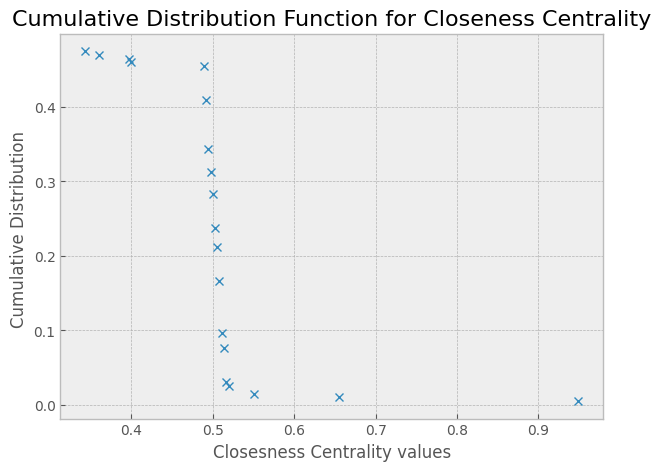

In [30]:
cdf = 0
for i in counter:
    cdf += counter[i]/len(G.nodes())

cdf_x = [] 
cdf_y = [] 
data_closeness_centrality_copy =  sp.copy() 
N = len(data_closeness_centrality_copy)
N_temp = N 
while data_closeness_centrality_copy:
    current_min = min(data_closeness_centrality_copy) 
    current_num = data_closeness_centrality_copy.count(current_min) 
    cdf_x.append(current_min) 
    cdf_y.append(N_temp/198) 
    N_temp = N_temp-current_num 
    for n in range(current_num):
        data_closeness_centrality_copy.remove(current_min)

plt.figure(figsize = (7,5))
plt.style.use('bmh')
plt.title('Cumulative Distribution Function for Closeness Centrality', fontsize = 16)

plt.plot(cdf_x,cdf_y,"x")
plt.xlabel('Closesness Centrality values')
plt.ylabel('Cumulative Distribution ')
